In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../scripts")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

In [3]:
from underwriting import client_surveillance_jupyter

In [48]:
import seaborn as sns; sns.set()
sns.set(rc={'figure.figsize':(10,5)})

In [4]:
COMPANY_IDENTIFIER = ['WVN']
TRANSFER_PACKAGES_START_DATE = '2020-01-01'
SALES_TRANSACTIONS_START_DATE = '2020-01-01'

In [5]:
#fetch download report and lisences
company_licenses_query = create_queries.create_company_licenses_query(COMPANY_IDENTIFIER)
company_download_summaries_query = create_queries.create_company_download_summaries_query(COMPANY_IDENTIFIER, TRANSFER_PACKAGES_START_DATE)

company_licenses_dataframe = pd.read_sql_query(company_licenses_query, engine)
company_download_summaries_dataframe = pd.read_sql_query(company_download_summaries_query, engine)

In [6]:
company_licenses_dataframe

,us_state,license_number,license_category,legal_name,is_current,license_status,rollup_id,license_description,company_id,facility_row_id
0,CA,C11-0000371-LIC,Distributor,IRRATIONAL RACCOON LLC,True,Active,CA-01956,Distributor,ce697634-40bc-4b7d-a8db-d0e26efe7a0b,None
1,CA,C11-0000497-LIC,Distributor,ZASP,True,Active,CA-04092,Distributor,ce697634-40bc-4b7d-a8db-d0e26efe7a0b,None


## Check download status summaries

In [7]:
license_numbers = company_download_summaries_dataframe['license_number'].unique()
download_summary_records = company_download_summaries_dataframe.to_dict('records')

In [8]:
license_numbers

array(['C11-0000371-LIC', 'C11-0000497-LIC'], dtype=object)

In [9]:
license_numbers = list(license_numbers)

In [10]:
license_numbers

['C11-0000371-LIC', 'C11-0000497-LIC']

In [11]:
bad_download_history = client_surveillance_jupyter.check_company_license_download(license_numbers,download_summary_records)
bad_download_history

Verifying download summaries for license C11-0000371-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-07-18

Verifying download summaries for license C11-0000497-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-07-18

[SUCCESS] All download summaries look good!


defaultdict(list, {})

# License check

In [12]:
company_licenses_dataframe

,us_state,license_number,license_category,legal_name,is_current,license_status,rollup_id,license_description,company_id,facility_row_id
0,CA,C11-0000371-LIC,Distributor,IRRATIONAL RACCOON LLC,True,Active,CA-01956,Distributor,ce697634-40bc-4b7d-a8db-d0e26efe7a0b,None
1,CA,C11-0000497-LIC,Distributor,ZASP,True,Active,CA-04092,Distributor,ce697634-40bc-4b7d-a8db-d0e26efe7a0b,None


In [13]:
company_state = list(company_licenses_dataframe['us_state'].unique())[0]
company_state

'CA'

## Pull data

In [14]:
company_incoming_transfer_packages_query = create_queries.create_company_incoming_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_outgoing_transfer_packages_query = create_queries.create_company_outgoing_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_unknown_transfer_packages_query = create_queries.create_company_unknown_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
#     license_numbers=license_numbers,
)
company_sales_transactions_query = create_queries.create_company_sales_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_query = create_queries.create_company_sales_receipts_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_with_transactions_query = create_queries.create_company_sales_receipts_with_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_inventory_packages_query = create_queries.create_company_inventory_packages_query(
    COMPANY_IDENTIFIER,
    include_quantity_zero=True,
    license_numbers=license_numbers,
)



company_incoming_transfer_packages_dataframe = pd.read_sql_query(company_incoming_transfer_packages_query, engine)
company_outgoing_transfer_packages_dataframe = pd.read_sql_query(company_outgoing_transfer_packages_query, engine)
company_unknown_transfer_packages_dataframe = pd.read_sql_query(company_unknown_transfer_packages_query, engine)
company_sales_transactions_dataframe = pd.read_sql_query(company_sales_transactions_query, engine)
company_sales_receipts_dataframe = pd.read_sql_query(company_sales_receipts_query, engine)
company_sales_receipts_with_transactions_dataframe = pd.read_sql_query(company_sales_receipts_with_transactions_query, engine)
company_inventory_packages_dataframe = pd.read_sql_query(company_inventory_packages_query, engine)

In [70]:
print(company_outgoing_transfer_packages_query)


		select
			case
				when company_deliveries.delivery_type = 'INCOMING_FROM_VENDOR' then 'INCOMING_FROM_VENDOR'
				when company_deliveries.delivery_type = 'INCOMING_UNKNOWN' then 'INCOMING_FROM_VENDOR'
				when company_deliveries.delivery_type = 'OUTGOING_UNKNOWN' then 'OUTGOING_TO_PAYOR'
				when company_deliveries.delivery_type = 'OUTGOING_TO_PAYOR' then 'OUTGOING_TO_PAYOR'
				else company_deliveries.delivery_type
			end as delivery_type,
			company_deliveries.license_number,
			metrc_transfers.manifest_number,
			metrc_transfers.created_date,
			metrc_deliveries.received_datetime,
			metrc_transfers.shipper_facility_license_number,
			metrc_transfers.shipper_facility_name,
			metrc_deliveries.recipient_facility_license_number,
			metrc_deliveries.recipient_facility_name,
			metrc_deliveries.shipment_type_name,
			metrc_deliveries.shipment_transaction_type,
			metrc_transfer_packages.package_id,
			metrc_transfer_packages.package_label,
			metrc_transfer_packages.type,
			metrc_tr

In [15]:
unknown_package_count = client_surveillance_jupyter.check_unknown_transfer_packages(company_unknown_transfer_packages_dataframe)
unknown_package_count

[SUCCESS] No unknown transfer packages!


0

In [16]:
#make sure we did pulled all location's data
company_incoming_transfer_packages_dataframe['license_number'].unique()

array(['C11-0000371-LIC', 'C11-0000497-LIC'], dtype=object)

In [17]:
company_outgoing_transfer_packages_dataframe['license_number'].unique()

array(['C11-0000497-LIC', 'C11-0000371-LIC'], dtype=object)

In [18]:
df_in = company_incoming_transfer_packages_dataframe
df_out = company_outgoing_transfer_packages_dataframe
df_in['created_date'] = pd.to_datetime(df_in['created_date'])
df_out['created_date'] = pd.to_datetime(df_out['created_date'])


In [19]:
df_in_irr = df_in[df_in['license_number'] == 'C11-0000371-LIC']
df_out_irr = df_out[df_out['license_number'] == 'C11-0000371-LIC']
df_in_zasp = df_in[df_in['license_number'] == 'C11-0000497-LIC']
df_out_zasp = df_out[df_out['license_number'] == 'C11-0000497-LIC']

In [73]:
df_out_irr['receiver_wholesale_price'].sum()

21184194.92

In [ ]:
#df_in_ext['product_name_lower'] = df_in_ext['product_name'].str.lower()

# 1. IRR's outgoing to dispensaries

In [34]:
df_out_irr[['delivery_type','package_id']].groupby('delivery_type').count()


,package_id
delivery_type,
OUTGOING_INTERNAL,1247
OUTGOING_TO_PAYOR,46199


In [37]:
df_out_irr[['shipment_type_name','package_id']].groupby('shipment_type_name').count()


,package_id
shipment_type_name,
Return,8
State Authorized,5
Transfer,9200
Wholesale Manifest,38233


In [32]:
df_out_irr[['is_testing_sample','package_id']].groupby('is_testing_sample').count()


,package_id
is_testing_sample,
False,47043
True,403


In [29]:
df_out_irr[['is_trade_sample','package_id']].groupby('is_trade_sample').count()


,package_id
is_trade_sample,
False,47446


In [41]:
df_out_irr_clean = df_out_irr[(df_out_irr['shipment_type_name'].isin(['Wholesale Manifest'])) &\
                              (~df_out_irr['is_testing_sample']) &\
                              (df_out_irr['delivery_type'] == 'OUTGOING_TO_PAYOR') &\
                              (df_out_irr['shipment_package_state'] == 'Accepted')]

In [43]:
df_out_irr_clean.head()

,delivery_type,license_number,manifest_number,created_date,received_datetime,shipper_facility_license_number,shipper_facility_name,recipient_facility_license_number,recipient_facility_name,shipment_type_name,shipment_transaction_type,package_id,package_label,type,source_package_labels,source_harvest_names,shipment_package_state,is_testing_sample,is_trade_sample,product_category_name,product_name,package_lab_results_status,shipper_wholesale_price,shipped_quantity,shipped_unit_of_measure,received_quantity,received_unit_of_measure,receiver_wholesale_price,item_unit_weight,item_unit_weight_unit_of_measure_name
91,OUTGOING_TO_PAYOR,C11-0000371-LIC,0003776808,2022-07-19,2022-07-19 20:05:30+00:00,C11-0000371-LIC,IRRATIONAL RACCOON LLC,C12-0000002-LIC,"TAHOE WELLNESS CENTER, INC.",Wholesale Manifest,Wholesale,27100684,1A4060300005F51000062929,transfer,1A4060300005F51000036708,"E1-Crescendo-2/9/22, E4-Crescendo-2/16/22, W1-...",Accepted,False,False,Flower (packaged eighth - each),THC-Zen-Crescendo-S-F-3.5-Sample,passed,0.01,1.0,Each,1.0,Each,0.01,3.5,Grams
99,OUTGOING_TO_PAYOR,C11-0000371-LIC,0003776808,2022-07-19,2022-07-19 20:05:30+00:00,C11-0000371-LIC,IRRATIONAL RACCOON LLC,C12-0000002-LIC,"TAHOE WELLNESS CENTER, INC.",Wholesale Manifest,Wholesale,27100686,1A4060300005F51000062930,transfer,1A4060300005F51000046548,"C1-XJ-13-1/5/22, C2-XJ-13-1/18/22, C4-XJ-13-12...",Accepted,False,False,Flower (packaged eighth - each),THC-Zen-XJ13-S-F-3.5-Sample,passed,0.01,1.0,Each,1.0,Each,0.01,3.5,Grams
120,OUTGOING_TO_PAYOR,C11-0000371-LIC,0003776808,2022-07-19,2022-07-19 20:05:30+00:00,C11-0000371-LIC,IRRATIONAL RACCOON LLC,C12-0000002-LIC,"TAHOE WELLNESS CENTER, INC.",Wholesale Manifest,Wholesale,27100685,1A4060300005F51000062932,transfer,1A4060300005F51000062188,"C1-XJ-13-3/1/22, C5-XJ-13-3/8/22",Accepted,False,False,Flower (packaged eighth - each),THC-Zen-XJ13-S-F-3.5,passed,592.00,32.0,Each,32.0,Each,592.00,3.5,Grams
156,OUTGOING_TO_PAYOR,C11-0000371-LIC,0003776808,2022-07-19,2022-07-19 20:05:30+00:00,C11-0000371-LIC,IRRATIONAL RACCOON LLC,C12-0000002-LIC,"TAHOE WELLNESS CENTER, INC.",Wholesale Manifest,Wholesale,27100681,1A4060300005F51000062933,transfer,1A4060300005F51000062186,"E4-Crescendo-4/20/22, E6-Crescendo-3/23/22, E8...",Accepted,False,False,Flower (packaged eighth - each),THC-Zen-Crescendo-S-F-3.5,passed,640.00,32.0,Each,32.0,Each,640.00,3.5,Grams
167,OUTGOING_TO_PAYOR,C11-0000371-LIC,0003776808,2022-07-19,2022-07-19 20:05:30+00:00,C11-0000371-LIC,IRRATIONAL RACCOON LLC,C12-0000002-LIC,"TAHOE WELLNESS CENTER, INC.",Wholesale Manifest,Wholesale,27100683,1A4060300005F51000062931,transfer,1A4060300005F51000054190,"E2-Garlic Cocktail-1/6/22, E3-Garlic Cocktail-...",Accepted,False,False,Flower (packaged eighth - each),THC-Zen-GC-I-F-3.5-Sample,passed,0.01,1.0,Each,1.0,Each,0.01,3.5,Grams


<AxesSubplot:xlabel='created_date'>

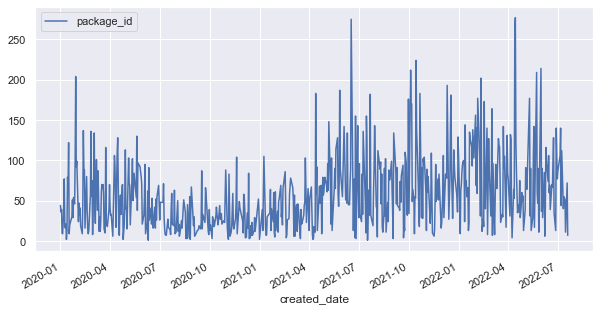

In [49]:
df_out_irr_clean[['created_date','package_id']].groupby('created_date').count().plot()

In [50]:
df_out_irr_clean.head()

,delivery_type,license_number,manifest_number,created_date,received_datetime,shipper_facility_license_number,shipper_facility_name,recipient_facility_license_number,recipient_facility_name,shipment_type_name,shipment_transaction_type,package_id,package_label,type,source_package_labels,source_harvest_names,shipment_package_state,is_testing_sample,is_trade_sample,product_category_name,product_name,package_lab_results_status,shipper_wholesale_price,shipped_quantity,shipped_unit_of_measure,received_quantity,received_unit_of_measure,receiver_wholesale_price,item_unit_weight,item_unit_weight_unit_of_measure_name
91,OUTGOING_TO_PAYOR,C11-0000371-LIC,0003776808,2022-07-19,2022-07-19 20:05:30+00:00,C11-0000371-LIC,IRRATIONAL RACCOON LLC,C12-0000002-LIC,"TAHOE WELLNESS CENTER, INC.",Wholesale Manifest,Wholesale,27100684,1A4060300005F51000062929,transfer,1A4060300005F51000036708,"E1-Crescendo-2/9/22, E4-Crescendo-2/16/22, W1-...",Accepted,False,False,Flower (packaged eighth - each),THC-Zen-Crescendo-S-F-3.5-Sample,passed,0.01,1.0,Each,1.0,Each,0.01,3.5,Grams
99,OUTGOING_TO_PAYOR,C11-0000371-LIC,0003776808,2022-07-19,2022-07-19 20:05:30+00:00,C11-0000371-LIC,IRRATIONAL RACCOON LLC,C12-0000002-LIC,"TAHOE WELLNESS CENTER, INC.",Wholesale Manifest,Wholesale,27100686,1A4060300005F51000062930,transfer,1A4060300005F51000046548,"C1-XJ-13-1/5/22, C2-XJ-13-1/18/22, C4-XJ-13-12...",Accepted,False,False,Flower (packaged eighth - each),THC-Zen-XJ13-S-F-3.5-Sample,passed,0.01,1.0,Each,1.0,Each,0.01,3.5,Grams
120,OUTGOING_TO_PAYOR,C11-0000371-LIC,0003776808,2022-07-19,2022-07-19 20:05:30+00:00,C11-0000371-LIC,IRRATIONAL RACCOON LLC,C12-0000002-LIC,"TAHOE WELLNESS CENTER, INC.",Wholesale Manifest,Wholesale,27100685,1A4060300005F51000062932,transfer,1A4060300005F51000062188,"C1-XJ-13-3/1/22, C5-XJ-13-3/8/22",Accepted,False,False,Flower (packaged eighth - each),THC-Zen-XJ13-S-F-3.5,passed,592.00,32.0,Each,32.0,Each,592.00,3.5,Grams
156,OUTGOING_TO_PAYOR,C11-0000371-LIC,0003776808,2022-07-19,2022-07-19 20:05:30+00:00,C11-0000371-LIC,IRRATIONAL RACCOON LLC,C12-0000002-LIC,"TAHOE WELLNESS CENTER, INC.",Wholesale Manifest,Wholesale,27100681,1A4060300005F51000062933,transfer,1A4060300005F51000062186,"E4-Crescendo-4/20/22, E6-Crescendo-3/23/22, E8...",Accepted,False,False,Flower (packaged eighth - each),THC-Zen-Crescendo-S-F-3.5,passed,640.00,32.0,Each,32.0,Each,640.00,3.5,Grams
167,OUTGOING_TO_PAYOR,C11-0000371-LIC,0003776808,2022-07-19,2022-07-19 20:05:30+00:00,C11-0000371-LIC,IRRATIONAL RACCOON LLC,C12-0000002-LIC,"TAHOE WELLNESS CENTER, INC.",Wholesale Manifest,Wholesale,27100683,1A4060300005F51000062931,transfer,1A4060300005F51000054190,"E2-Garlic Cocktail-1/6/22, E3-Garlic Cocktail-...",Accepted,False,False,Flower (packaged eighth - each),THC-Zen-GC-I-F-3.5-Sample,passed,0.01,1.0,Each,1.0,Each,0.01,3.5,Grams


## a. payer churn

In [52]:
PC_START_DATE = '2020-01-01'
PC_END_DATE = '2022-06-01'
PC_MONTH_LIST = ['2022-03-01','2022-04-01','2022-05-01','2022-06-01']
PC_MONTH_END = PC_MONTH_LIST[-1]

In [65]:
def calculate_payer_churn(
    outgoing_df, pc_start_date, pc_end_date, pc_month_list
):

    outgoing_df["year_month"] = pd.to_datetime(
        outgoing_df["created_date"]
    ).dt.strftime("%Y-%m")
    
    pc = (
        outgoing_df[
            ["year_month", "recipient_facility_license_number", "receiver_wholesale_price"]
        ]
        .groupby(["year_month", "recipient_facility_license_number"])
        .sum()
        .reset_index()
    )
    
    
    pc = pc.assign(year_month=lambda df: pd.to_datetime(df["year_month"]))

    pc_full = (
        (
            pc.groupby("recipient_facility_license_number").apply(
                lambda df: df.merge(
                    pd.Series(
                        None,
                        index=pd.date_range(
                            start=pc_start_date, end=pc_end_date, freq="MS"
                        ),
                        name="__place_holder",
                    ),
                    how="right",
                    left_on="year_month",
                    right_index=True,
                )
                .assign(
                    **{
                        "receiver_wholesale_price": lambda df_: df_.receiver_wholesale_price.fillna(
                            0
                        ),
                    }
                )
                .drop(["__place_holder", "recipient_facility_license_number"], axis=1)
            )
        )
        .reset_index()
        .drop(["level_1"], axis=1)
    ).round(2)

    rolling_4m_sum = pc_full.groupby("recipient_facility_license_number").apply(
        lambda df: df.set_index("year_month").sort_index().rolling(4).sum()
    )
    rolling_4m_sum.columns = ["rolling_4m_total_price"]
    facility_monthly_running_total = pc_full.groupby("recipient_facility_license_number").apply(
        lambda df: df.set_index("year_month")
        .sort_index()["receiver_wholesale_price"]
        .cumsum()
        .to_frame()
    )
    facility_monthly_running_total.columns = ["facility_running_total"]
    monthly_running_total = (
        facility_monthly_running_total.reset_index()
        .groupby("year_month")["facility_running_total"]
        .sum()
        .to_frame()
    )
    monthly_running_total.columns = ["monthly_running_total"]

    pc_result = (
        rolling_4m_sum.merge(
            facility_monthly_running_total,
            how="inner",
            left_index=True,
            right_index=True,
        )
        .reset_index()
        .merge(monthly_running_total, how="left", on="year_month")
    ).round(2)
    pc_result["%_total"] = (
        pc_result["facility_running_total"] / pc_result["monthly_running_total"]
    )
    pc_result["last_4m_active"] = pc_result["rolling_4m_total_price"] > 0
    pc_result["significant"] = pc_result["%_total"] > 0.001
    pc_result["measure"] = pc_result.apply(
        lambda row: "Active"
        if (row["last_4m_active"] & row["significant"])
        else ("Inactive" if row["significant"] else "Exclude"),
        axis=1,
    )
    # churn
    churn = (
        pc_result.groupby(["year_month"])
        .apply(lambda x: x[x["measure"] == "Inactive"]["%_total"].sum())
        .reset_index()
    )
    churn.columns = ["year_month", "%_inactive"]
    churn.index = churn.year_month

    # output vendor churn matrix
    pc_data = pc_full[pc_full["year_month"] <= pc_end_date]
    pc_data["year_month"] = pc_data["year_month"].astype(str)
    pc_matrix = pd.pivot_table(
        pc_data,
        values="receiver_wholesale_price",
        index="recipient_facility_license_number",
        columns="year_month",
        fill_value=0,
    ).reset_index()
    pc_matrix["facility_total"] = pc_matrix.sum(axis=1)
    pc_matrix["grand_total"] = pc_matrix["facility_total"].sum()
    pc_matrix["perc_total"] = pc_matrix["facility_total"] / pc_matrix["grand_total"]
    pc_matrix["last_4m_total"] = pc_matrix[pc_month_list].sum(axis=1)
    pc_matrix["last_4m_active"] = pc_matrix["last_4m_total"] > 0
    pc_matrix["significant"] = pc_matrix["perc_total"] > 0.001
    pc_matrix["measure"] = pc_matrix.apply(
        lambda row: "Active"
        if (row["last_4m_active"] & row["significant"])
        else ("Inactive" if row["significant"] else "Exclude"),
        axis=1,
    )
    return churn, pc_matrix

In [66]:
churn,pc_matrix = calculate_payer_churn(df_out_irr_clean,PC_START_DATE,PC_END_DATE,PC_MONTH_LIST)


In [68]:
df_out_irr_clean[df_out_irr_clean['recipient_facility_license_number'] == 'C10-0000515-LIC']


,delivery_type,license_number,manifest_number,created_date,received_datetime,shipper_facility_license_number,shipper_facility_name,recipient_facility_license_number,recipient_facility_name,shipment_type_name,shipment_transaction_type,package_id,package_label,type,source_package_labels,source_harvest_names,shipment_package_state,is_testing_sample,is_trade_sample,product_category_name,product_name,package_lab_results_status,shipper_wholesale_price,shipped_quantity,shipped_unit_of_measure,received_quantity,received_unit_of_measure,receiver_wholesale_price,item_unit_weight,item_unit_weight_unit_of_measure_name,year_month
2382,OUTGOING_TO_PAYOR,C11-0000371-LIC,0003691409,2022-06-29,2022-06-30 17:06:24+00:00,C11-0000371-LIC,IRRATIONAL RACCOON LLC,C10-0000515-LIC,"RHMT, LLC",Wholesale Manifest,Wholesale,26533393,1A4060300005F51000061398,transfer,1A4060300005F51000061008,"G - S030122 - Room 3 Harvest, Gar - S031522 - ...",Accepted,False,False,Flower (packaged eighth - each),HOP-Supercell-I-F-3.5,passed,2880.0,96.0,Each,96.0,Each,2880.0,3.5,Grams,2022-06
2403,OUTGOING_TO_PAYOR,C11-0000371-LIC,0003691409,2022-06-29,2022-06-30 17:06:24+00:00,C11-0000371-LIC,IRRATIONAL RACCOON LLC,C10-0000515-LIC,"RHMT, LLC",Wholesale Manifest,Wholesale,26533394,1A4060300005F51000061402,transfer,1A4060300005F51000061010,C5-XJ-13-3/8/22,Accepted,False,False,Flower (packaged eighth - each),HOP-DiabloWind-S-F-3.5-X,passed,2880.0,96.0,Each,96.0,Each,2880.0,3.5,Grams,2022-06
2407,OUTGOING_TO_PAYOR,C11-0000371-LIC,0003691409,2022-06-29,2022-06-30 17:06:24+00:00,C11-0000371-LIC,IRRATIONAL RACCOON LLC,C10-0000515-LIC,"RHMT, LLC",Wholesale Manifest,Wholesale,26533398,1A4060300005F51000061401,transfer,1A4060300005F51000058690,C7-Peanut Butter Souffle-10/19/21,Accepted,False,False,Pre-Roll Flower,HOP-IceFog-H-PR-7Pack-3.5,passed,1920.0,64.0,Each,64.0,Each,1920.0,3.5,Grams,2022-06
2423,OUTGOING_TO_PAYOR,C11-0000371-LIC,0003691409,2022-06-29,2022-06-30 17:06:24+00:00,C11-0000371-LIC,IRRATIONAL RACCOON LLC,C10-0000515-LIC,"RHMT, LLC",Wholesale Manifest,Wholesale,26533399,1A4060300005F51000061400,transfer,1A4060300005F51000059034,C6-24k-1/25/22,Accepted,False,False,Pre-Roll Flower,HOP-PinkMoon-I-PR-7Pack-3.5,passed,1920.0,64.0,Each,64.0,Each,1920.0,3.5,Grams,2022-06
2517,OUTGOING_TO_PAYOR,C11-0000371-LIC,0003691409,2022-06-29,2022-06-30 17:06:24+00:00,C11-0000371-LIC,IRRATIONAL RACCOON LLC,C10-0000515-LIC,"RHMT, LLC",Wholesale Manifest,Wholesale,26533396,1A4060300005F51000061396,transfer,1A4060300008981000181354,000188 P05 Harvest Bay6 24NOV2021,Accepted,False,False,Pre-Roll Flower,HOP-SteamDevil-S-PR-7Pack-3.5,passed,960.0,32.0,Each,32.0,Each,960.0,3.5,Grams,2022-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206333,OUTGOING_TO_PAYOR,C11-0000371-LIC,0000234492,2020-01-07,2020-01-07 18:39:36+00:00,C11-0000371-LIC,IRRATIONAL RACCOON LLC,C10-0000515-LIC,"RHMT, LLC",Wholesale Manifest,Wholesale,1902972,1A4060300005F51000004405,transfer,1A4060300004D2B000000284,,Accepted,False,False,Tincture (volume - each),Serpentine Tincture,failed,500.0,20.0,Each,20.0,Each,500.0,NaN,None,2020-01
207650,OUTGOING_TO_PAYOR,C11-0000371-LIC,0000225313,2020-01-01,2020-01-02 20:00:11+00:00,C11-0000371-LIC,IRRATIONAL RACCOON LLC,C10-0000515-LIC,"RHMT, LLC",Wholesale Manifest,Wholesale,1773762,1A4060300005F51000004150,transfer,1A4060300004D2B000000288,,Accepted,False,False,Vape Cartridge (volume - each),Blue Kush Cartridge,failed,720.0,40.0,Each,40.0,Each,720.0,NaN,None,2020-01
207663,OUTGOING_TO_PAYOR,C11-0000371-LIC,0000225313,2020-01-01,2020-01-02 20:00:11+00:00,C11-0000371-LIC,IRRATIONAL RACCOON LLC,C10-0000515-LIC,"RHMT, LLC",Wholesale Manifest,Wholesale,1773763,1A4060300005F51000004149,transfer,1A4060300004D2B000000300,,Accepted,False,False,Vape Cartridge (volume - each),Pink Puma Cartridge,failed,720.0,40.0,Each,40.0,Each,720.0,NaN,None,2020-01
207669,OUTGOING_TO_PAYOR,C11-0000371-LIC,0000225313,2020-01-01,

In [67]:
pc_matrix.sort_values(by = 'perc_total',ascending = False)

year_month,recipient_facility_license_number,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,facility_total,grand_total,perc_total,last_4m_total,last_4m_active,significant,measure
174,C10-0000515-LIC,19365.00,4567.78,11290.00,1124.25,1720.00,920.0,6040.00,2070.0,500.0,23366.0,59457.0,24589.25,60883.0,68149.35,87607.80,88485.86,42894.67,58594.40,12692.00,6720.00,0.00,6720.00,6720.00,6720.00,5760.09,2880.00,8640.00,6720.0,9600.30,13440.0,648236.75,19114381.22,3.391356e-02,38400.30,True,True,Active
178,C10-0000523-LIC,12040.00,6899.39,7295.00,395.00,5168.25,1140.0,10350.00,3228.0,0.0,18298.5,21543.0,14389.50,47085.5,38293.20,29891.35,72459.12,45265.30,34765.30,11370.00,7680.00,0.00,4800.00,4980.00,0.00,5760.00,0.00,2880.00,2880.0,960.20,5760.0,415576.61,19114381.22,2.174157e-02,12480.20,True,True,Active
123,C10-0000348-LIC,3200.04,722.06,5928.04,2326.00,2200.02,0.0,1097.00,0.0,0.0,0.0,0.0,0.00,3275.0,0.00,10617.50,15651.00,24750.05,19970.29,15453.42,34336.92,26363.04,22477.50,24671.29,18429.53,27851.05,25544.11,31527.33,30412.5,27021.34,18465.1,392290.13,19114381.22,2.052330e-02,107426.27,True,True,Active
177,C10-0000522-LIC,5057.00,3525.25,2160.00,0.15,2688.00,0.0,4794.00,0.0,660.0,4685.0,15984.0,14527.50,40343.0,25839.45,39129.53,66432.98,19224.80,39779.70,14320.00,6720.00,1920.00,3840.00,6720.00,5760.00,5760.00,2880.00,3840.00,5760.0,3840.20,6720.0,352910.56,19114381.22,1.846309e-02,20160.20,True,True,Active
144,C10-0000413-LIC,2500.04,722.06,6569.04,2326.00,2480.05,0.0,1135.75,0.0,0.0,0.0,0.0,0.00,3200.0,0.00,10627.50,9216.00,23357.55,4967.05,15253.30,31199.87,20119.74,15406.62,22568.41,29466.55,28510.54,19771.40,23359.50,29614.0,20786.85,17764.1,340921.92,19114381.22,1.783589e-02,91524.45,True,True,Active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,C10-0000420-LIC,0.00,0.01,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.01,19114381.22,5.231663e-10,0.00,False,False,Exclude
355,C12-0000068-LIC,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,19114381.22,0.000000e+00,0.00,False,False,Exclude
306,C10-0001041-LIC,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,19114381.22,0.000000e+00,0.00,False,False,Exclude
397,C12-0000373-LIC,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,19114381.22,0.000000e+00,0.00,False,False,Exclude


In [69]:

pc_matrix[pc_matrix['recipient_facility_license_number'] == 'C10-0000279-LIC']

year_month,recipient_facility_license_number,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,facility_total,grand_total,perc_total,last_4m_total,last_4m_active,significant,measure


In [ ]:
in_data = df_in_ext_clean[['received_datetime','shipper_facility_license_number','shipper_facility_name',\
                            'shipment_type_name','package_id','product_name','shipped_quantity','received_quantity','received_unit_of_measure']]
in_data.columns = ['received_datetime_in','shipper_facility_license_number_in','shipper_facility_name_in',\
                            'shipment_type_name_in','package_id','product_name_in','shipped_quantity_in','received_quantity_in','received_unit_of_measure_in']

In [ ]:
out_data = df_out[['received_datetime',\
                      'recipient_facility_license_number','recipient_facility_name','package_id',\
                      'product_name','shipped_quantity','received_quantity','received_unit_of_measure']]
out_data.columns = ['received_datetime_out',\
                      'recipient_facility_license_number_out','recipient_facility_name_out','package_id',\
                      'product_name_out','shipped_quantity_out','received_quantity_out','received_unit_of_measure_out']


In [ ]:
j = in_data.merge(out_data,how = 'left',on = ['package_id'])

In [ ]:
j.shape

# Vendor churn

In [ ]:
VC_START_DATE = '2020-01-01'
VC_END_DATE = '2022-05-01'
VC_MONTH_LIST = ['2022-02-01','2022-03-01','2022-04-01','2022-05-01']
VC_MONTH_END = VC_MONTH_LIST[-1]

In [ ]:
license_numbers

In [ ]:
df_in['delivery_type'].unique()

In [ ]:
df_out.head()

In [ ]:
test_pkg

In [ ]:
df_in[df_in['package_id'] == '24408766']

In [ ]:
df_out[df_out['package_id'] == '24408766']

In [ ]:
test_pkg[(test_pkg['recipient_facility_name'].notnull())&(test_pkg['received_datetime_x'] < test_pkg['received_datetime_y'])]


In [ ]:
df_in[df_in['package_id'] == '24408766']

In [ ]:
df_out[df_out['package_id'] == '24408766']

In [ ]:
df_out[df_out['recipient_facility_license_number'] == 'C12-0000392-LIC']

In [ ]:
test_pkg[test_pkg['recipient_facility_name'].notnull()].shape[0] / test_pkg.shape[0]

In [ ]:
churn,vc_matrix = client_surveillance_jupyter.calculate_vendor_churn(company_incoming_transfer_packages_dataframe,license_numbers,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST)


In [ ]:
churn_short,vc_matrix_short = client_surveillance_jupyter.calculate_vendor_churn_short(company_incoming_transfer_packages_dataframe,license_numbers,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)


In [ ]:
churn_short

In [ ]:
ax = churn['%_inactive'].plot(marker = 'o',figsize = (12,8),label = 'VC old')
ax = churn_short['%_inactive'].plot(marker = 'o',figsize = (12,8),label = 'VC short')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
ax = plt.title('Rolling 4m vendor churn')
ax = plt.legend()

# Receiver wholesale price outlier check

In [ ]:
per_unit_incoming_package_sort,per_unit_incoming_product_sort = client_surveillance_jupyter.check_per_unit_incoming(company_incoming_transfer_packages_dataframe)


In [ ]:
# top 5
print('Top 5 per unit incoming packages')
per_unit_incoming_package_sort.head(20)

In [ ]:
print('Bottom 5 per unit incoming packages')
per_unit_incoming_package_sort.dropna().tail(5)


In [ ]:
# look at large cost items if any
company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['per_unit_incoming'] > 10000]

# COGS analysis

In [ ]:
df_in = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['per_unit_incoming'] <= 10000]
df_inventory = company_inventory_packages_dataframe
df_sales = deduped_sales_receipts_with_transactions_dataframe

In [ ]:
df_summary_simp,df_cogs_average_product = client_surveillance_jupyter.cogs_analysis(df_in,df_sales,'monthly',company_state)


In [ ]:
df_summary_simp

In [ ]:
df_summary_simp_uom,df_cogs_average_product_uom = client_surveillance_jupyter.cogs_analysis_uom(df_in,df_sales,'monthly',company_state)


In [ ]:
j = df_sales.merge(df_in,how= 'left',left_on = 'tx_package_id',right_on = 'package_id')

In [ ]:
j[(j['tx_unit_of_measure']!= j['shipped_unit_of_measure'])&(j['shipped_unit_of_measure'].notnull())][['sales_month','tx_package_id','tx_product_name','tx_product_category_name','tx_unit_of_measure','shipped_unit_of_measure','per_unit','per_unit_incoming']].head()



In [ ]:
import seaborn as sns; sns.set()
sns.set(rc={'figure.figsize':(10,5)})

In [ ]:
df_summary_simp['margin_%'] - df_summary_simp_uom['margin_%']

In [ ]:
plt.scatter(df_summary_simp['margin_%'] ,df_summary_simp_uom['margin_%'] )
plt.xlabel('GM% original')
plt.ylabel('GM% improved')


In [ ]:
df_summary_simp[[ 'revenue', 'cogs', 'margin_$', 'margin_%']]

In [ ]:
df_summary_simp_uom[[ 'revenue', 'cogs', 'margin_$', 'margin_%']]

# Revenue change vs state

In [ ]:
if COMPANY_IDENTIFIER == ['NECC']:
    a = client_surveillance_jupyter.calculate_quarterly_sum_gmv_ma_short(df_summary_simp)
    a

In [ ]:
if COMPANY_IDENTIFIER == ['NECC']:
    round(a.dropna()['total'].sum(),2)

In [ ]:
a = client_surveillance_jupyter.get_gmv_change(company_state,df_summary_simp)
round(a.dropna()['total'].sum(),2)

In [ ]:
a

# Inventory

In [ ]:
today = date.today()
today

In [ ]:
COMPANY_IDENTIFIER

In [ ]:
license_numbers

In [ ]:
df_inventory.head()

In [ ]:
df_in['created_date'] = pd.to_datetime(df_in['created_date'])

In [ ]:
df_in_recent

In [ ]:
df_in_recent = df_in[df_in['created_date'] >= '2022-01-01']

In [ ]:
df_in_recent.head()

In [ ]:
df_inventory['package_id'].nunique()

In [ ]:
df_inventory_license = client_surveillance_jupyter.calculate_inventory_valuation(df_in_recent,df_inventory,license_numbers,today)

In [ ]:
df_inventory_license

In [ ]:
df_inventory_license_msrp = client_surveillance_jupyter.calculate_msrp_based_inventory_valuation(df_in,df_sales,df_inventory,license_numbers,today)

In [ ]:
df_inventory_license_msrp

In [ ]:
df_inventory_fresh,_ = client_surveillance_jupyter.calculate_inventory_valuation_fresh(df_in,df_inventory,license_numbers,today,0,90)

In [ ]:
df_inventory_fresh

In [ ]:
_['age_int'].describe()

# Quantity based inventory TO

In [ ]:
df_inventory.head()

In [ ]:
inventory_q = df_inventory[['package_id','unit_of_measure','quantity']].groupby(['package_id','unit_of_measure']).sum()



In [ ]:
inventory_q = inventory_q.reset_index()
inventory_q

In [ ]:
df_sales_3m = df_sales[df_sales['sales_month'] >= '2022-03']

In [ ]:
sales_q = df_sales_3m[['tx_package_id','tx_unit_of_measure','tx_quantity_sold']].groupby(['tx_package_id','tx_unit_of_measure']).sum()
sales_q = sales_q.reset_index()


In [ ]:
j = inventory_q.merge(sales_q,how = 'left',left_on = ['package_id','unit_of_measure'],right_on = ['tx_package_id','tx_unit_of_measure'])



In [ ]:
j['to'] = j['tx_quantity_sold'] / j['quantity'] * 4

In [ ]:
j[j['to'] >= 50]

In [ ]:
j['to'].describe()

# Repayment score

In [ ]:
company_repayment_data

In [ ]:
company_repayment_data_due = company_repayment_data[company_repayment_data['adjusted_maturity_date'] < today]

In [ ]:
company_repayment_data_due


In [ ]:
company_repayment_data_due['weight'] = company_repayment_data_due['loan_amount'] / sum(company_repayment_data_due['loan_amount'])

In [ ]:
len(company_repayment_data_due)

In [ ]:
if len(company_repayment_data_due) == 0:
    weighted_dpd = numpy.nan
else:
    weighted_dpd = sum(company_repayment_data_due['days_late'] * company_repayment_data_due['weight'])

    

In [ ]:
weighted_dpd

In [ ]:
repayment_score = client_surveillance_jupyter.get_short_repayment_score(weighted_dpd)
repayment_score

# Create Template: updated

In [ ]:
current_month = '2022-05'
full_score = 45

In [ ]:
license_numbers

In [ ]:
template_new_ = client_surveillance_jupyter.create_template_update(a,df_summary_simp,df_inventory_license,df_inventory_license_msrp,df_inventory_fresh,churn_short,retial_license_check_df,license_numbers,company_state,current_month)



In [ ]:
template_new_

# Output data 

In [ ]:
license_numbers

## others

In [ ]:
# for only 1 license
license_number = license_numbers[0]
template_new_.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month + '/template/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_inventory_fresh.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_inventory_fresh.csv')
df_inventory_license_msrp.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_inventory_msrp.csv')
df_summary_simp.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_short.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_short.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
a.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')
#retial_license_check_df



In [ ]:
# multiple licenses
template_new_.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month + '/template/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) +'_template.csv')
df_inventory_license.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today)  +'_inventory_val.csv')
df_inventory_fresh.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) +'_inventory_fresh.csv')
df_inventory_license_msrp.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) +'_inventory_msrp.csv')
df_summary_simp.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE +'_cogs.csv')
vc_matrix_short.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE  +'_vc_matrix.csv')
churn_short.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE  +'_vc.csv')
a.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE  +'_rev_change_vs_state.csv')
#retial_license_check_df



# Appendix

In [ ]:
# def calculate_quarterly_sum_gmv_ma_short(cogs_analysis_df):

#     gmv_df = cogs_analysis_df[(cogs_analysis_df['date'] >= '2021-09')&(cogs_analysis_df['date'] <= '2022-02')][['revenue_change']]
#     gmv_df['sum_gmv_change_ma'] = [-0.07,0.09,-0.11,0.02]
#     gmv_df['weight'] = [0.76,0.84,0.92,1]
#     gmv_df['variance'] = gmv_df['revenue_change'] - gmv_df['sum_gmv_change_ma']
#     gmv_df['points'] = [gmv_change_variance_point_mapping(n) for n in gmv_df['variance']]
#     gmv_df.replace([numpy.inf, -numpy.inf], numpy.nan, inplace=True)
#     gmv_df['total'] = gmv_df['points'] * gmv_df['weight']
#     return gmv_df
    